In [1]:
pip install transformers datasets scikit-learn accelerate evaluate

In [2]:
import pandas as pd
from datasets import Dataset, DatasetDict

# 1) Load CSV
df = pd.read_csv("data_comment with label.csv", sep=';')

# 2) Map string labels to ints
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

df["label_id"] = df["label"].map(label2id)

# 3) Split train / test
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label_id"], random_state=42)

# 4) Convert to HuggingFace Dataset
train_ds = Dataset.from_pandas(train_df[["text", "label_id"]])
test_ds = Dataset.from_pandas(test_df[["text", "label_id"]])

datasets = DatasetDict({
    "train": train_ds,
    "test": test_ds
})

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "j-hartmann/sentiment-roberta-large-english-3-classes"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
HTTP Error 504 thrown while requesting HEAD https://huggingface.co/j-hartmann/sentiment-roberta-large-english-3-classes/resolve/main/config.json
Retrying in 1s [Retry 1/5].
Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the chec

In [4]:
def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_datasets = datasets.map(tokenize_fn, batched=True)

# Trainer expects column "labels"
tokenized_datasets = tokenized_datasets.rename_column("label_id", "labels")
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/72 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

In [5]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

In [6]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

training_args = TrainingArguments(
    output_dir="./sentiment-roberta-finetuned",
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_steps=50,
    report_to="none" # Explicitly disable reporting to experiment trackers like wandb
)

# Instantiate DataCollatorWithPadding to handle dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    # Replaced 'tokenizer=tokenizer' with 'data_collator=data_collator'
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [7]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [8]:
trainer.train()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.533793,0.888889,0.888500
2,No log,0.940030,0.777778,0.769697
3,No log,1.057090,0.777778,0.769697


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=27, training_loss=0.277880209463614, metrics={'train_runtime': 1667.8568, 'train_samples_per_second': 0.13, 'train_steps_per_second': 0.016, 'total_flos': 50324463654912.0, 'train_loss': 0.277880209463614, 'epoch': 3.0})

In [9]:
trainer.evaluate()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.5337926149368286,
 'eval_accuracy': 0.8888888888888888,
 'eval_f1_macro': 0.8885003885003885,
 'eval_runtime': 30.8576,
 'eval_samples_per_second': 0.583,
 'eval_steps_per_second': 0.065,
 'epoch': 3.0}

In [10]:
trainer.save_model("./sentiment-roberta-finetuned")
tokenizer.save_pretrained("./sentiment-roberta-finetuned")


('./sentiment-roberta-finetuned/tokenizer_config.json',
 './sentiment-roberta-finetuned/special_tokens_map.json',
 './sentiment-roberta-finetuned/vocab.json',
 './sentiment-roberta-finetuned/merges.txt',
 './sentiment-roberta-finetuned/added_tokens.json',
 './sentiment-roberta-finetuned/tokenizer.json')

Now we are going to use new model, fine tune model result


In [20]:
from transformers import pipeline

clf = pipeline( #clf is model classifier
    "text-classification",
    model="./sentiment-roberta-finetuned",
    tokenizer="./sentiment-roberta-finetuned",
    return_all_scores=True
)

print(clf("The product is amazing, I really love it!"))


Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'negative', 'score': 0.00012211276043672115}, {'label': 'neutral', 'score': 0.00018095645646099}, {'label': 'positive', 'score': 0.9996969699859619}]]


Read new data from data_comment.csv and save it in dataframe

In [21]:
df_data = pd.read_csv("data_comment.csv", sep=';')
text_column = "comment" # define which coloum as the dataText

In [22]:
if text_column not in df_data.columns:
    raise ValueError(f"Comment coloum '{text_column}' is not found in your CSV file. List of data coloum : {list(df.columns)}")

texts = df_data[text_column].fillna("").astype(str).tolist()

Done! Saved with sentiment to: reviews_with_sentiment_model2.csv


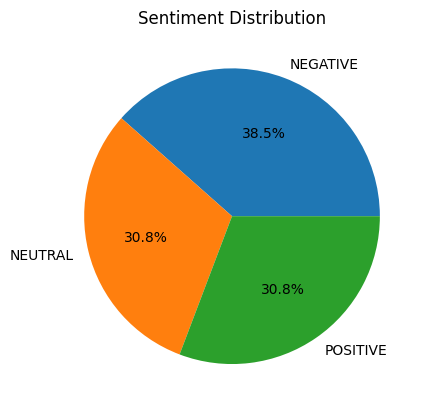

In [26]:
# ==== Predict all texts ====
results = clf(texts, batch_size=32, truncation=True)

pred_labels = []
max_scores = []
neg_scores = []
neu_scores = []
pos_scores = []

for item in results:
    # item = list of dict: [{'label': 'negative', 'score': ...}, ...]
    # choose the label with the highest score
    best = max(item, key=lambda x: x["score"])
    pred_labels.append(best["label"])     # 'negative' / 'neutral' / 'positive'
    max_scores.append(best["score"])

    # take all the scores
    score_dict = {d["label"]: d["score"] for d in item}
    neg_scores.append(score_dict.get("negative", None))
    neu_scores.append(score_dict.get("neutral", None))
    pos_scores.append(score_dict.get("positive", None))

# ==== 5. Input the result to dataframe ====
df_data["sentiment_label"] = pred_labels          # negative / neutral / positive
df_data["sentiment_confidence"] = max_scores
df_data["score_negative"] = neg_scores
df_data["score_neutral"] = neu_scores
df_data["score_positive"] = pos_scores

# Define OUTPUT_CSV_model2 before use
OUTPUT_CSV_model2 = "reviews_with_sentiment_model2.csv"

# ==== 6. Save in new csv file ====
df_data.to_csv(OUTPUT_CSV_model2, index=False)
print(f"Done! Saved with sentiment to: {OUTPUT_CSV_model2}")

# ==== PIE CHART ====
counts = df_data["sentiment_label"].value_counts()

plt.figure()
plt.pie(
    counts,
    labels=[lbl.upper() for lbl in counts.index],  # POSITIVE / NEGATIVE / NEUTRAL
    autopct="%1.1f%%"
)
plt.title("Sentiment Distribution")
plt.show()